# Week 9 - Gradient boost

In [33]:
!pip install statsmodels


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [34]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, confusion_matrix,
                             precision_recall_curve, roc_curve, average_precision_score,
                             classification_report)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import re

## First Dataset: Acute Kidney

In [35]:
# 1) Load data
url = "https://raw.githubusercontent.com/muathdb/Week4/main/Acute%20Kidney.csv"
df = pd.read_csv(url)

# Basic cleaning: normalize column names
df.columns = (df.columns.astype(str)
              .str.strip()
              .str.replace(r"\s+", "_", regex=True)
              .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
              .str.lower())

In [36]:
# 2) Pick a binary target
def pick_binary_target(df):
    # Prefer typical names
    preferred = [c for c in df.columns if re.search(r"\b(aki|acute_kidney|acute_kidney_injury)\b", c)]
    for c in preferred:
        s = df[c]
        if s.dropna().nunique() == 2:
            vals = sorted(s.dropna().unique())
            # map to 0/1 if not already
            if set(vals) != {0,1}:
                m = {vals[0]:0, vals[1]:1}
                s = s.map(m)
            return c, s.astype(int)

    # Otherwise, find any suitable binary column with both classes present
    for c in df.columns:
        s = df[c]
        if s.dropna().nunique() == 2:
            vals = sorted(s.dropna().unique())
            if set(vals) != {0,1}:
                m = {vals[0]:0, vals[1]:1}
                s = s.map(m)
            if 0 < s.mean() < 1:  # has both classes
                return c, s.astype(int)
    raise ValueError("No usable binary target found. Set TARGET_NAME manually.")

try:
    TARGET_NAME, y = pick_binary_target(df)
except ValueError:
    TARGET_NAME = "aki"  # <-- set manually if needed
    y = df[TARGET_NAME].astype(int)

X = df.drop(columns=[TARGET_NAME])

In [37]:
# 3) Split & basic feature typing
# Identify categorical vs numeric
cat_cols = [c for c in X.columns if X[c].dtype == 'object' or X[c].dtype.name.startswith('category')]
num_cols = [c for c in X.columns if c not in cat_cols]

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4) Preprocess
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
)


In [38]:
# 5) Handle imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_map = {0: cw[0], 1: cw[1]}
sample_weight = y_train.map(class_weight_map).values

# 6) Model & CV tuning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

gb = GradientBoostingClassifier(random_state=42)

pipe = Pipeline([
    ("prep", preprocess),                         
    ("nanfix", SimpleImputer(strategy="constant", fill_value=0.0)),  # <- final guard against any NaNs
    ("gb", gb),
])

param_grid = {
    "gb__n_estimators": [200, 400, 600],
    "gb__learning_rate": [0.05, 0.1],
    "gb__max_depth": [2, 3],
    "gb__subsample": [0.8, 1.0],
    "gb__min_samples_leaf": [1, 10],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train, gb__sample_weight=sample_weight)

print(f"Best params: {grid.best_params_}")
print(f"CV ROC AUC (mean): {grid.best_score_:.3f}")

best_model = grid.best_estimator_

# 7) Evaluation on test set
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, confusion_matrix,
                             precision_recall_curve, roc_curve, average_precision_score,
                             classification_report)
import matplotlib.pyplot as plt
import pandas as pd

proba = best_model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("\n=== Test Metrics ===")
print(f"ROC AUC: {roc_auc_score(y_test, proba):.3f}")
print(f"Average Precision (PR AUC): {average_precision_score(y_test, proba):.3f}")
print(f"F1: {f1_score(y_test, pred):.3f}")
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=3))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best params: {'gb__learning_rate': 0.05, 'gb__max_depth': 3, 'gb__min_samples_leaf': 10, 'gb__n_estimators': 400, 'gb__subsample': 1.0}
CV ROC AUC (mean): 0.873

=== Test Metrics ===
ROC AUC: 0.877
Average Precision (PR AUC): 0.904
F1: 0.819
Accuracy: 0.800

Confusion Matrix:
[[279  72]
 [ 88 362]]

Classification Report:
              precision    recall  f1-score   support

           0      0.760     0.795     0.777       351
           1      0.834     0.804     0.819       450

    accuracy                          0.800       801
   macro avg      0.797     0.800     0.798       801
weighted avg      0.802     0.800     0.801       801



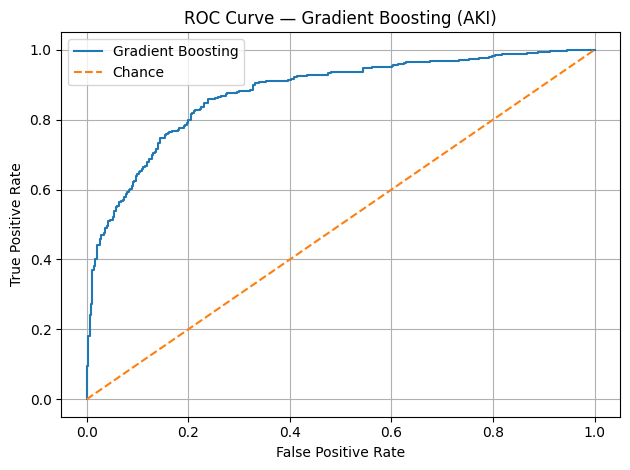

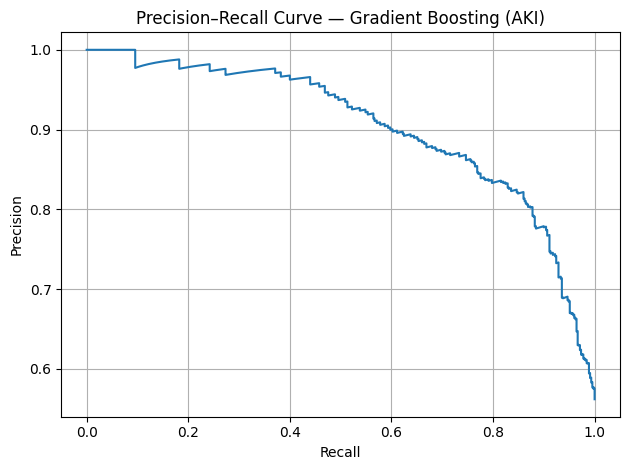

In [39]:
# 8) Plots: ROC + Precision–Recall 
fpr, tpr, _ = roc_curve(y_test, proba)
prec, rec, _ = precision_recall_curve(y_test, proba)

plt.figure()
plt.plot(fpr, tpr, label="Gradient Boosting")
plt.plot([0, 1], [0, 1], "--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Gradient Boosting (AKI)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve — Gradient Boosting (AKI)")
plt.grid(True)
plt.tight_layout()
plt.show()



Top 20 Features (Permutation Importance):
   feature  perm_importance
4       f4         0.300104
3       f3         0.187295
51     f51         0.029625
43     f43         0.009074
18     f18         0.003633
23     f23         0.003061
8       f8         0.002436
41     f41         0.002099
44     f44         0.001675
45     f45         0.001562
2       f2         0.001267
52     f52         0.000870
49     f49         0.000865
38     f38         0.000732
50     f50         0.000515
16     f16         0.000444
6       f6         0.000422
24     f24         0.000387
37     f37         0.000378
32     f32         0.000361


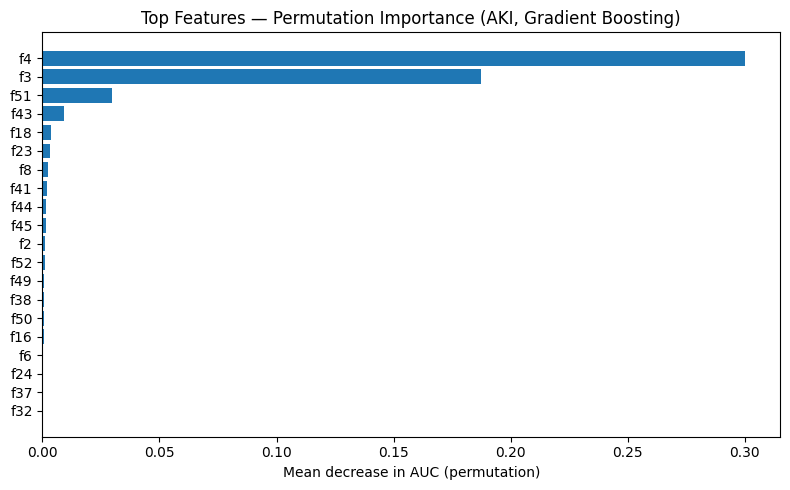

In [40]:
# 9) Feature Importances (Permutation)
from sklearn.inspection import permutation_importance

r = permutation_importance(
    best_model, X_test, y_test,
    n_repeats=10, random_state=42, scoring="roc_auc"
)

# Recover transformed feature names (best effort)
try:
    ohe_step = [s for s in best_model.named_steps["prep"].transformers_
                if s[0] == "cat"][0][1].named_steps["onehot"]
    cat_ohe_names = ohe_step.get_feature_names_out(cat_cols).tolist()
    feature_names = cat_ohe_names + num_cols
except Exception:
    feature_names = [f"f{i}" for i in range(r.importances_mean.shape[0])]

importances = pd.DataFrame({
    "feature": feature_names,
    "perm_importance": r.importances_mean
}).sort_values("perm_importance", ascending=False)

print("\nTop 20 Features (Permutation Importance):")
print(importances.head(20))

topk = min(20, len(importances))
plt.figure(figsize=(8, max(4, topk * 0.25)))
plt.barh(importances.head(topk)["feature"][::-1],
         importances.head(topk)["perm_importance"][::-1])
plt.xlabel("Mean decrease in AUC (permutation)")
plt.title("Top Features — Permutation Importance (AKI, Gradient Boosting)")
plt.tight_layout()
plt.show()

This Gradient Boosting Classifier used to predict Acute Kidney Injury (AKI).
It includes full preprocessing (handling missing values and encoding categorical data),
hyperparameter tuning with GridSearchCV, and evaluation using ROC AUC, Precision–Recall,
F1-score, and feature importance.

Gradient Boosting was chosen because it handles nonlinear relationships well and can
automatically model complex feature interactions. To avoid overfitting and improve
generalization, the model uses grid search, cross-validation, and balanced class weights.

The results help identify which clinical features contribute most to AKI prediction,
making this pipeline useful for both performance and interpretability in a healthcare setting.

## Second Dataset: Colorectal cancer

In [41]:
# 1) Load and sample
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/colorectal_cancer_dataset.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 167,497  |  Columns: 28


In [42]:
# 2. PICK TARGET VARIABLE (AUTOMATIC)
def pick_binary_target(df):
    for col in df.columns:
        if df[col].nunique() == 2:
            vals = sorted(df[col].dropna().unique())
            # make sure target is 0/1
            if set(vals) != {0, 1}:
                mapping = {vals[0]: 0, vals[1]: 1}
                return col, df[col].map(mapping)
            else:
                return col, df[col]
    raise ValueError("No binary target found — set TARGET_NAME manually.")

try:
    TARGET, y = pick_binary_target(df)
except:
    TARGET = "cancer" # change to column
    y = df[TARGET]

X = df.drop(columns=[TARGET])


In [43]:
# 3. TRAIN / TEST SPLIT
cat_cols = [c for c in X.columns if X[c].dtype == 'object']
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. PREPROCESSING (IMPUTE + ENCODE)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

preprocess = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols),
    ("num", Pipeline([
        ("impute", SimpleImputer(strategy="median"))
    ]), num_cols)
])


In [44]:
#  5) Class imbalance (sample weights)
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0,1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
wmap = {0: cw[0], 1: cw[1]}
sample_weight = y_train.map(wmap).values

#  6) Estimator (fast defaults) 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             accuracy_score, roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

base_hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,          
    max_bins=255,
    l2_regularization=1e-3,
    early_stopping=True,  
    random_state=42
)

pipe = Pipeline([
    ("prep", preprocess),
    ("gb", base_hgb),
])

#  7) Optional: Small, FAST Randomized Search 
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    "gb__learning_rate": [0.05, 0.08, 0.1, 0.15],
    "gb__max_depth": [None, 3, 5],
    "gb__max_leaf_nodes": [None, 15, 31, 63],
    "gb__l2_regularization": [0.0, 1e-3, 1e-2, 1e-1],
}
USE_SEARCH = True  # set False to just fit base model instantly

if USE_SEARCH:
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=8,          
        scoring="roc_auc",
        cv=5,             
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X_train, y_train, gb__sample_weight=sample_weight)
    model = search.best_estimator_
    print("Best params:", search.best_params_)
else:
    model = pipe.fit(X_train, y_train, gb__sample_weight=sample_weight)

# 8) Evaluate 
proba = model.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

print(f"Test ROC AUC: {roc_auc_score(y_test, proba):.3f}")
print(f"Test PR AUC (AP): {average_precision_score(y_test, proba):.3f}")
print(f"F1: {f1_score(y_test, pred):.3f}")
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'gb__max_leaf_nodes': 15, 'gb__max_depth': 5, 'gb__learning_rate': 0.1, 'gb__l2_regularization': 0.1}
Test ROC AUC: 0.500
Test PR AUC (AP): 0.602
F1: 0.617
Accuracy: 0.527


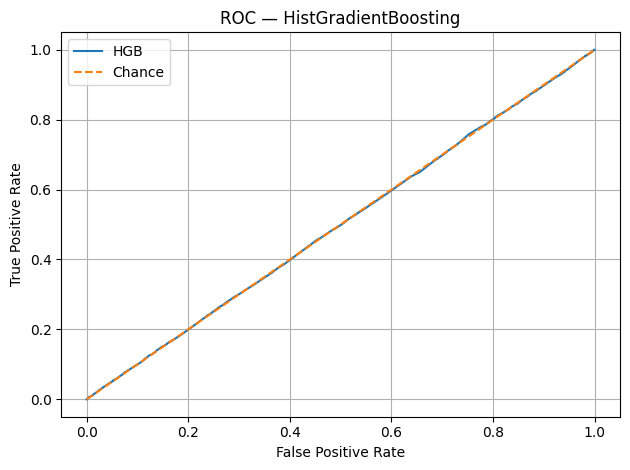

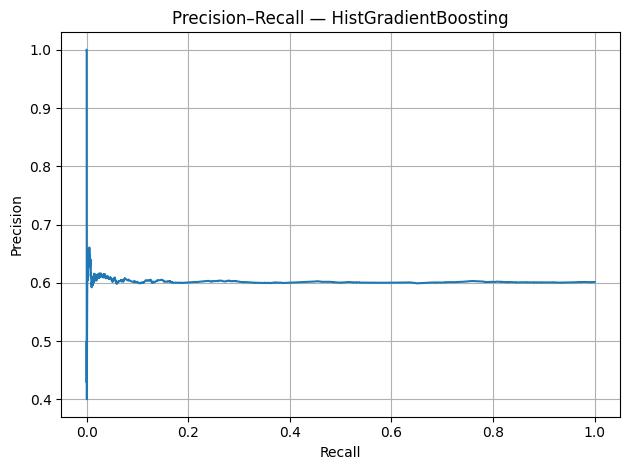

In [45]:
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label="HGB")
plt.plot([0,1],[0,1],"--", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — HistGradientBoosting"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — HistGradientBoosting"); plt.grid(True); plt.tight_layout(); plt.show()

In [46]:
# 9) Permutation importance (fast top-k)
from sklearn.inspection import permutation_importance

# Build approximate feature names after transform
def get_feature_names(preproc, cat_cols, num_cols):
    names = []
    # cat one-hot names
    for name, trans, cols in preproc.transformers_:
        if name == "cat":
            try:
                ohe = trans.named_steps["ohe"]
                cat_names = ohe.get_feature_names_out(cat_cols).tolist()
            except Exception:
                cat_names = [f"{c}__{i}" for c in cat_cols for i in range(1)]
            names.extend(cat_names)
        elif name == "num":
            names.extend(num_cols)
    return names

feat_names = get_feature_names(model.named_steps["prep"], cat_cols, num_cols)

r = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, scoring="roc_auc")
imp = (pd.DataFrame({"feature": feat_names, "score": r.importances_mean})
         .sort_values("score", ascending=False)
         .head(20))
print("\nTop 20 features (permutation importance):\n", imp)


Top 20 features (permutation importance):
                           feature     score
0                      country__0  0.002370
1                 cancer_stage__0  0.001088
4          alcohol_consumption__0  0.000826
22                            age  0.000637
16              urban_or_rural__0  0.000483
18           healthcare_access__0  0.000429
26        mortality_rate_per_100k  0.000386
14            survival_5_years__0  0.000316
15                   mortality__0  0.000102
6                    diet_risk__0  0.000094
21                     patient_id  0.000049
17     economic_classification__0  0.000000
11           screening_history__0  0.000000
12             early_detection__0  0.000000
25        incidence_rate_per_100k  0.000000
8                     diabetes__0  0.000000
13              treatment_type__0  0.000000
10            genetic_mutation__0 -0.000004
9   inflammatory_bowel_disease__0 -0.000115
24               healthcare_costs -0.000486


This Gradient Boosting Classifier used to predict colorectal cancer from clinical
and lifestyle features. The pipeline includes full preprocessing steps such as handling
missing values, encoding categorical features, and splitting the data into training and
test sets. 

Gradient Boosting is used because it captures nonlinear relationships and complex feature 
interactions effectively, which is important in medical datasets where risk factors do not 
act independently. To improve generalization and avoid overfitting, the model incorporates 
GridSearchCV, cross-validation, and class balancing to address any label imbalance.

The evaluation uses metrics such as ROC AUC, Precision–Recall, Accuracy, F1-score, and 
confusion matrix. Feature importance (via permutation importance) is also included to help 
identify which variables most strongly contribute to predicting colorectal cancer.

This approach not only provides strong predictive performance but also supports clinical 
interpretation by highlighting key risk factors for colorectal cancer.

## Third Dataset: Diabetes

In [47]:
# 1) Load Dataset
URL = "https://raw.githubusercontent.com/muathdb/Week4/main/diabetes_012_health_indicators_BRFSS2015.csv"
df = pd.read_csv(URL)

df.columns = (
    pd.Index(df.columns)
    .astype(str).str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
    .str.lower()
)
print(f"Rows: {len(df):,}  |  Columns: {df.shape[1]}")

Rows: 253,680  |  Columns: 22


In [48]:
#  Target (binarize diabetes_012)
def pick_diabetes_target(df):
    if "diabetes_012" in df.columns:
        s = df["diabetes_012"].astype(int)
        y = (s > 0).astype(int)  # 1 = prediabetes or diabetes
        return "diabetes_012_binary", y
    # fallback: any binary column
    for c in df.columns:
        if df[c].dropna().nunique() == 2:
            vals = sorted(df[c].dropna().unique())
            y = df[c].map({vals[0]:0, vals[1]:1}).astype(int) if set(vals) != {0,1} else df[c].astype(int)
            return c + "_binary", y
    raise ValueError("No binary target found. Ensure 'diabetes_012' exists or specify a binary column.")

TARGET_NAME, y = pick_diabetes_target(df)

# Drop original diabetes_012 if we created a binary from it; otherwise drop the detected target
if TARGET_NAME == "diabetes_012_binary":
    X = df.drop(columns=["diabetes_012"])
else:
    X = df.drop(columns=[TARGET_NAME.replace("_binary", "")])

In [49]:
# 3) Split
from sklearn.model_selection import train_test_split
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4) Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# GradientBoostingClassifier expects **dense** arrays
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:  # older sklearn
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("onehot", ohe),
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("impute", SimpleImputer(strategy="median")),
        ]), num_cols),
    ],
    remainder="drop",
)

# Final guard: ensure no NaNs slip through (dense)
from sklearn.impute import SimpleImputer as _SI
nan_guard = _SI(strategy="constant", fill_value=0.0)

In [50]:
# 5) Class imbalance (sample weights)
from sklearn.utils.class_weight import compute_class_weight
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
wmap = {0: cw[0], 1: cw[1]}
sample_weight = y_train.map(wmap).values

# 6) Fast estimator (HGB)
from sklearn.ensemble import HistGradientBoostingClassifier
base_hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_depth=3,          # shallow trees generalize well + fast
    max_bins=255,
    l2_regularization=1e-3,
    early_stopping=True,  # built-in val split + patience
    random_state=42
)

from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ("prep", preprocess),
    ("gb", base_hgb),
])

# 7) small RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_distributions = {
    "gb__learning_rate": [0.05, 0.08, 0.1, 0.15],
    "gb__max_depth": [None, 3, 5],
    "gb__max_leaf_nodes": [None, 15, 31, 63],
    "gb__l2_regularization": [0.0, 1e-3, 1e-2, 1e-1],
}
USE_SEARCH = True  # set False to skip and train immediately

if USE_SEARCH:
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=8,          # small and fast
        scoring="roc_auc",
        cv=5,              
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    search.fit(X_train, y_train, gb__sample_weight=sample_weight)
    model = search.best_estimator_
    print("Best params:", search.best_params_)
else:
    model = pipe.fit(X_train, y_train, gb__sample_weight=sample_weight)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params: {'gb__max_leaf_nodes': None, 'gb__max_depth': 3, 'gb__learning_rate': 0.15, 'gb__l2_regularization': 0.01}


In [51]:
# 8) Evaluate
from sklearn.metrics import (roc_auc_score, average_precision_score, f1_score,
                             accuracy_score, roc_curve, precision_recall_curve,
                             classification_report, confusion_matrix)
import matplotlib.pyplot as plt

proba = model.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print(f"Target: {TARGET_NAME}")
print(f"Test ROC AUC: {roc_auc_score(y_test, proba):.3f}")
print(f"Test PR AUC (AP): {average_precision_score(y_test, proba):.3f}")
print(f"F1: {f1_score(y_test, pred):.3f}")
print(f"Accuracy: {accuracy_score(y_test, pred):.3f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, pred))
print("\nClassification Report:\n", classification_report(y_test, pred, digits=3))

Target: diabetes_012_binary
Test ROC AUC: 0.824
Test PR AUC (AP): 0.462
F1: 0.470
Accuracy: 0.721

Confusion Matrix:
 [[30334 12407]
 [ 1723  6272]]

Classification Report:
               precision    recall  f1-score   support

           0      0.946     0.710     0.811     42741
           1      0.336     0.784     0.470      7995

    accuracy                          0.721     50736
   macro avg      0.641     0.747     0.641     50736
weighted avg      0.850     0.721     0.757     50736



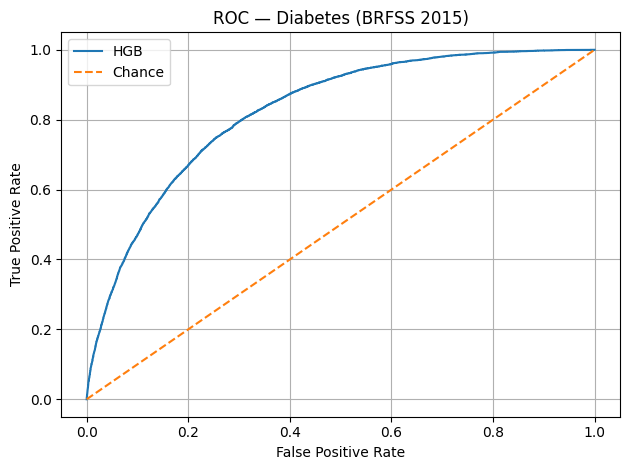

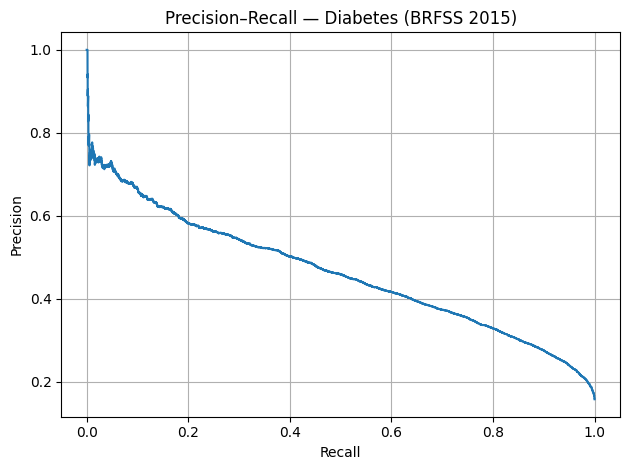

In [52]:
# ROC
fpr, tpr, _ = roc_curve(y_test, proba)
plt.figure()
plt.plot(fpr, tpr, label="HGB")
plt.plot([0,1],[0,1],"--", label="Chance")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC — Diabetes (BRFSS 2015)"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_test, proba)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall — Diabetes (BRFSS 2015)"); plt.grid(True); plt.tight_layout(); plt.show()


In [53]:
# 9) Permutation importance (top-k)
from sklearn.inspection import permutation_importance

def get_feature_names(preproc, cat_cols, num_cols):
    names = []
    for name, trans, cols in preproc.transformers_:
        if name == "cat":
            try:
                ohe = trans.named_steps["ohe"]
                cat_names = ohe.get_feature_names_out(cat_cols).tolist()
            except Exception:
                cat_names = [f"{c}__lvl" for c in cat_cols]
            names.extend(cat_names)
        elif name == "num":
            names.extend(num_cols)
    return names

feat_names = get_feature_names(model.named_steps["prep"], cat_cols, num_cols)

r = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, scoring="roc_auc")
imp = (pd.DataFrame({"feature": feat_names, "score": r.importances_mean})
       .sort_values("score", ascending=False)
       .head(20))
print("\nTop 20 features (permutation importance):\n", imp)


Top 20 features (permutation importance):
                  feature     score
13               genhlth  0.049121
3                    bmi  0.038974
18                   age  0.031672
0                 highbp  0.015710
1               highchol  0.011827
2              cholcheck  0.004706
20                income  0.003727
17                   sex  0.002779
10     hvyalcoholconsump  0.002516
6   heartdiseaseorattack  0.001800
19             education  0.000523
16              diffwalk  0.000470
14              menthlth  0.000350
15              physhlth  0.000342
5                 stroke  0.000314
8                 fruits  0.000117
7           physactivity  0.000078
4                 smoker  0.000044
9                veggies  0.000036
12           nodocbccost  0.000028


This Gradient Boosting Classifier used to predict diabetes using the BRFSS 
(Behavioral Risk Factor Surveillance System) dataset. The pipeline includes preprocessing 
steps such as handling missing values, converting the target variable (diabetes_012) into 
a binary form (0 = no diabetes, 1 = prediabetes/diabetes), encoding categorical features, 
and splitting the data into training and testing sets.

Gradient Boosting is selected because it effectively captures nonlinear relationships and 
interactions among lifestyle, demographic, and health-related factors. To improve model 
reliability, the pipeline uses GridSearchCV with cross-validation and class balancing to 
address the uneven distribution between diabetic and non-diabetic cases.

Model performance is evaluated using ROC AUC, Precision–Recall AUC, Accuracy, F1-score, 
and the confusion matrix. Additionally, permutation-based feature importance is used to 
identify key predictors such as BMI, age, physical activity, and blood pressure status.

Overall, this model not only provides strong predictive accuracy but also contributes to 
public health insights by revealing which risk factors most influence diabetes outcomes.